<a href="https://colab.research.google.com/github/ViniciusMangueira/Data_Science/blob/main/Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Churn**, o que é e como prever com Machine Learning!


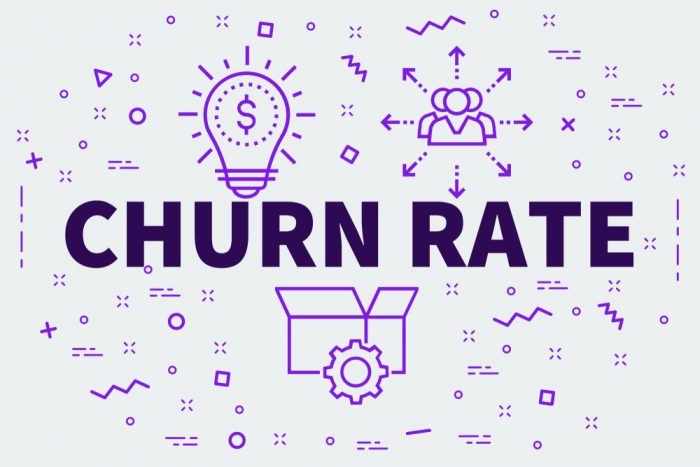

**“O Churn da empresa está baixo!”**

Você saberia dizer se isso é bom ou ruim? Ou seja, você sabe o que significa Churn? 

Em resumo, Churn é a métrica que indica o número dos clientes que cancelam em determinado período de tempo. Logo, quanto menor o valor do Churn melhor para empresa!

Você já deve ter pensado consigo mesmo que então esse tal de **Churn** é muito importante, não é? Eu respondo que, com certeza, SIM! Esse valor é uma das formas que uma empresa tem para ver como o seu negócio está indo, um Churn alto pode indicar que alguns processos da empresa podem estar ruins para os clientes e até mesmo ultrapassados.

Vemos um exemplo abaixo:

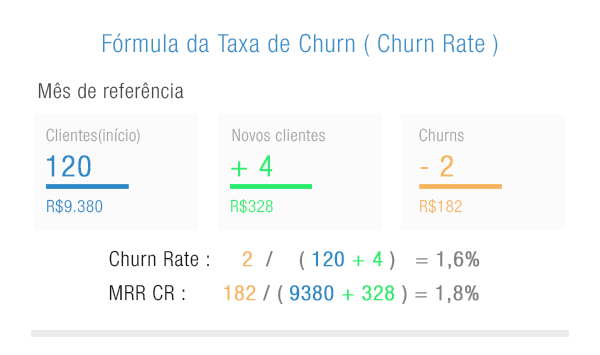

Nesse projeto, irei analisar os dados de uma companhia de telecomunicações os quais você pode encontrar nesse [link](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#). Escolhi esse dataset, pois o valor do Churn é um problema típico desse tipo de empresa.

Vamos ver a integridade dos dados, posteriormente, reparar as características das pessoas que são consideradas Churn e, por fim, fazer um modelo de Machine Learning que preveja se uma pessoa é Churn ou não!

## Importação dos dados

Inicialmente, vamos importar as bibliotecas e o dataset e na sequência veremos o formato do arquivo e suas 5 primeiras entradas!

In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [3]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Importar Arquivo
df = pd.read_csv("https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [5]:
# Visualização das 5 primeiras entradas do arquivo
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# Formato do arquivo
print("O arquivo tem {} linhas e {} colunas!".format(df.shape[0], df.shape[1]))

O arquivo tem 7043 linhas e 21 colunas!


## Análise Inicial

Nesse momento, estamos interessados em saber quais são os tipos das variáveis.

In [7]:
# Visualização dos nomes das colunas e os seus respectivos tipos
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Um ponto a se destacar é que `TotalCharges` está como **object** e não **float**. Dessa forma, iremos fazer a alteração do tipo da variável. 


No entanto, antes de fazermos as mudanças, vamos criar uma cópia do dataset original afim de deixar os dados originais intactos.

In [8]:
# Cópia
df_new = df.copy()

Agora, iremos apagar a coluna `customerID`, pois é o ID do usuário e não nos acrescentará nada em nossa análise. 

In [9]:
# Remover coluna costumerID
df_new.drop("customerID", axis=1, inplace=True)

Feito isso, iremos construir uma função para a alteração do tipo da nossa variável como já havíamos dito.

Após a construção iremos fazer alteração.


In [10]:
def converter_str_float(entrada):
    """
    Converte um objeto do tipo string em float.

    # Arguments
        entrada: string, string da coluna TotalCharges.

    # Returns
        Valor convertido em float, caso permita a conversão.
        NaN, caso o valor não seja apropriado.
    """

    try:
        return float(entrada)
    except ValueError:
        return np.nan


In [11]:
# Converter as strings de TotalCharges para float
df_new["TotalCharges"] = df_new["TotalCharges"].apply(converter_str_float)

In [12]:
# Verficar a alteração
df_new["TotalCharges"].dtype

dtype('float64')

### Dados Faltantes

Na sequência, queremos verificar a integridade do nosso dataset. Para isto, veremos se existem dados faltantes no dataset.

In [13]:
df_new.isnull().sum().sort_values(ascending=False)

TotalCharges        11
Churn                0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
gender               0
dtype: int64

Após a construção iremos fazer alteração. Percebemos que só `TotalCharges` possui valores faltantes, como é uma variável numérica e possui poucos dados faltantes, iremos substituir os valores ‘NaN’ pelo valor da mediana do atributo.

In [14]:
# Substituir os dados ausentes pelo valor da mediana
TotalChargesMedian = df_new.TotalCharges.median()
df_new["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

### Outliers

Ao fim da nossa análise inicial, queremos ver se existem outliers no dataset para podermos exclui-los a fim de que, no futuro, eles não atrapalhem nossos insights. 

In [15]:
# Ver estatísticas do dataset
df_new.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Pela tabela acima, vemos que `TotalCharges` talvez possua outliers. Para verificar melhor, vamos construir um boxplot.

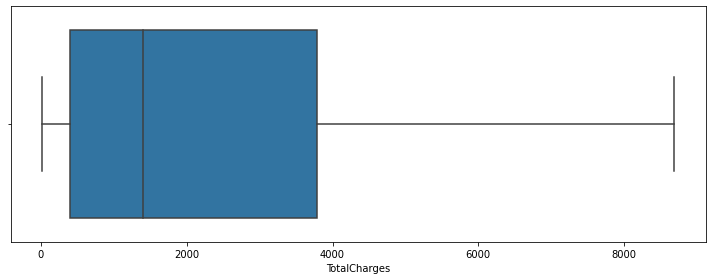

In [16]:
# Boxplot de TotalCharges
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(df_new['TotalCharges'])
plt.tight_layout()

Como verificamos acima `TotalCharges` não possui outliers, pois o threshold padrão não acusou nenhum plot fora dos limites superior e inferior.

## Análise de Churn por:

Como já dito, queremos verificar e, posteriormente, prever o número de Churn.

Inicialmente, vamos fazer algumas análises sobre as características das pessoas que cancelaram o serviço e depois construir o modelo de Machine Learning.


Assim, começaremos analisando a quantidade de cancelamentos por **Sexo** e depois por **Tipos de Pagamento** e **Suporte**, respectivamente. Por último, veremos com quantos meses os assinantes costumam ficar antes de cancelar. 

Para isso, vamos criar um Subdataset com os dados somente das pessoas que cancelaram sua assinatura. 

In [17]:
# Cópia 
df_churn = df_new[df_new['Churn']=='Yes'].copy()
df_no_churn = df_new[df_new['Churn']=='No'].copy()

Formato do subdatset com dados das pessoas que cancelaram sua assinatura: (1869, 20)
Formato do subdatset com dados das pessoas que não cancelaram sua assinatura: (5174, 20)


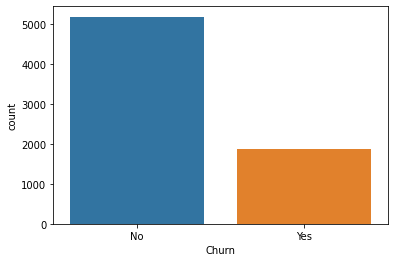

In [18]:
# Formato
print("Formato do subdatset com dados das pessoas que cancelaram sua assinatura: {}".format(df_churn.shape))
print("Formato do subdatset com dados das pessoas que não cancelaram sua assinatura: {}".format(df_no_churn.shape))
sns.countplot(df_new.Churn);

Vemos que os dois subdatasets estão um pouco de disparidade com relação a quantidade de dados. No futuro, ao preparar os dados para o modelo de Machine Learning isso será levado em conta.

### Sexo

Um fato interessante para a empresa é saber qual sexo tem mais evasão. Assim, faremos a comparação entre a quantidade de pessoas dos sexos masculinos e femininos que cancelaram e permaneceram com a assinatura. 

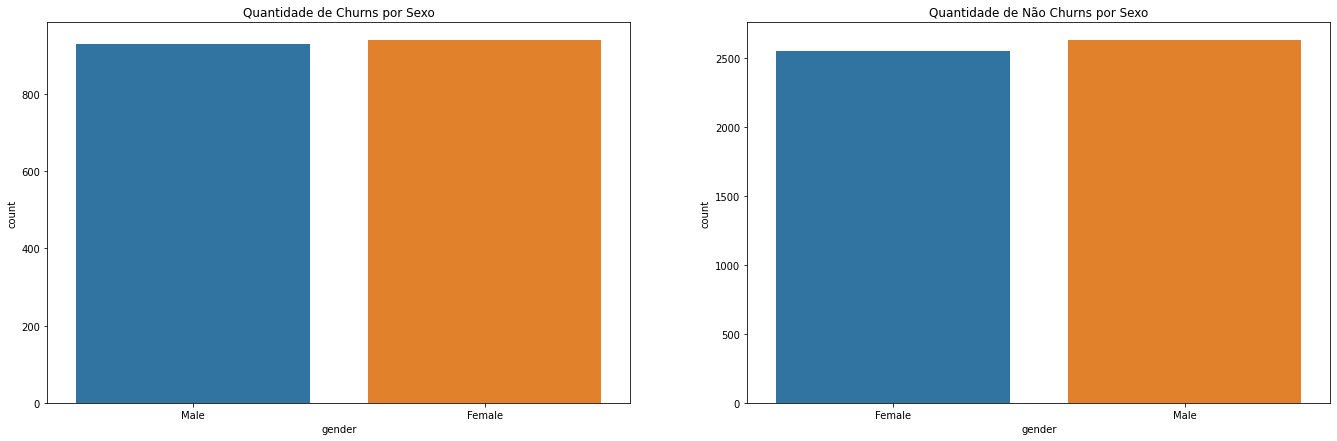

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(23, 7))

sns.countplot(df_churn.gender, ax=ax[0])
ax[0].set_title('Quantidade de Churns por Sexo');

sns.countplot(df_no_churn.gender, ax=ax[1])
ax[1].set_title("Quantidade de Não Churns por Sexo");

Acima, vemos que a diferença da quantidade por sexo é pequena. Mesmo assim, embora a quantidade de homens registrados seja maior, fica registrado que mulheres são as que mais cancelam a assinatura e em contrapartida homens tendem mais a ficar com a assinatura.

Visto isso, a empresa pode fazer alguma campanha destinada ao sexo feminino que aumente a sua permanência!


### Tipo de Pagamento

Outro fator importante, são os tipos de pagamento. Vamos analisá-los agora.

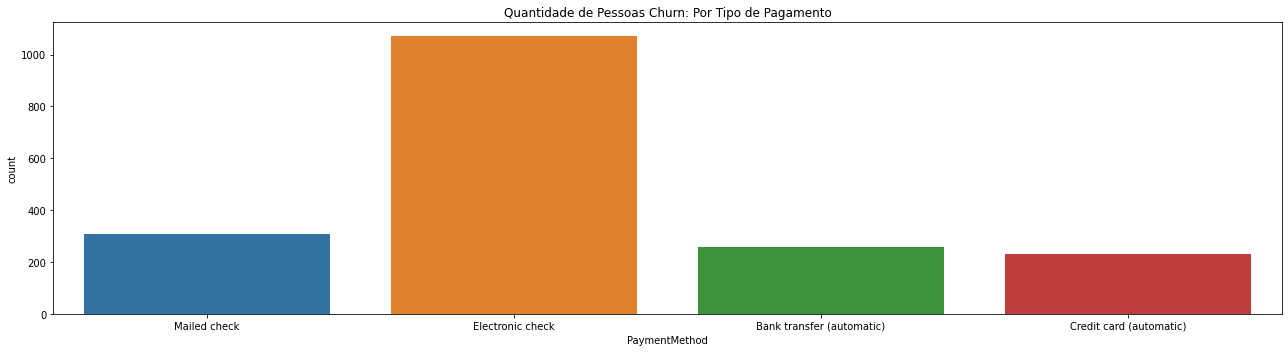

In [35]:
fig, ax = plt.subplots(figsize=(18, 5));
sns.countplot(df_churn.PaymentMethod);
plt.title("Quantidade de Pessoas Churn: Por Tipo de Pagamento");
plt.tight_layout();

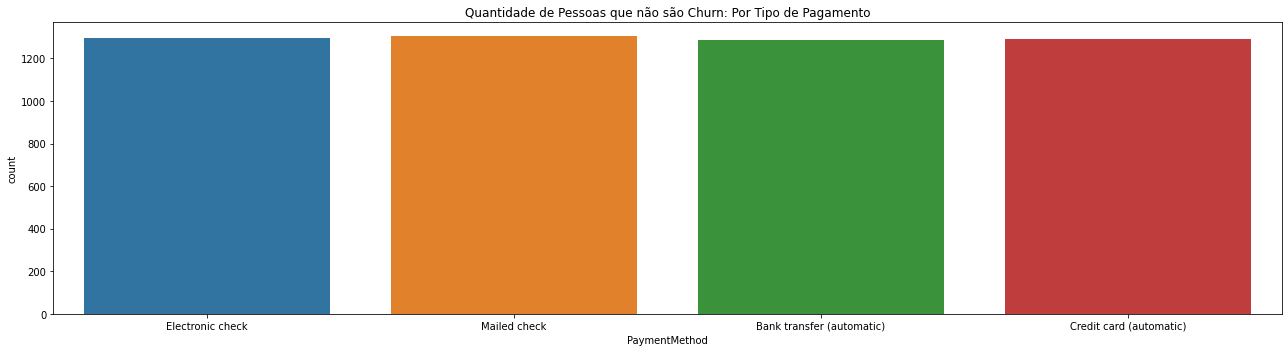

In [36]:
fig, ax = plt.subplots(figsize=(18, 5));
sns.countplot(df_no_churn.PaymentMethod);
plt.title("Quantidade de Pessoas que não são Churn: Por Tipo de Pagamento");
plt.tight_layout();

Visto os gráficos, temos que a maioria das pessoas utiliza **Eletronic check** como forma de pagamento seguido por, respectivamente, **Mailed check**, **Bank transfer** e **Credit card**.

O fato mais importante a ser visto, com relacao a comparação dos 3 graficos, é a quantidade de pessoas que cancelam e utilizam a forma de pagamento Cheque eletrônico.  Vemos que quase metade das pessoas que utilizaram esse tipo de pagamento cancelaram. Isso pode significar que pode haver algum tipo de problema que cause irritação no cliente a ponto dele querer cancelar.

Dessa forma, é importante que a empresa veja como está sendo o processo do Cheque Eletrônico para modernizá-lo ou até mesmo retirá-lo das suas opções!


### Suporte Técnico 


Abaixo veremos os gráficos das análises sobre os assinantes que possuem ou não Suporte Técnico. Notamos que a maioria das pessoas que possuem serviços de internet não gostam do suporte técnico. Dentre elas a esmagadora maioria que cancelou o serviço não gostava do suporte!

Logo, outro fator a ser repensado é a forma como o suporte técnico é feito para o cliente, afim de deixar quem mais interessa satisfeito! Pois, até mesmo a maioria que permanece com o serviço, não gosta do suporte.


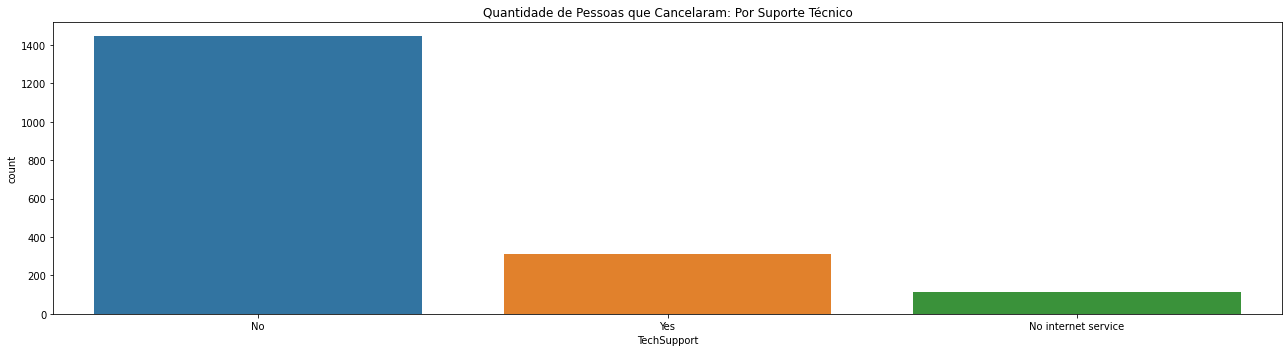

In [22]:
fig, ax = plt.subplots(figsize=(18, 5));
sns.countplot(df_churn.TechSupport);
plt.title("Quantidade de Pessoas que Cancelaram: Por Suporte Técnico");
plt.tight_layout();

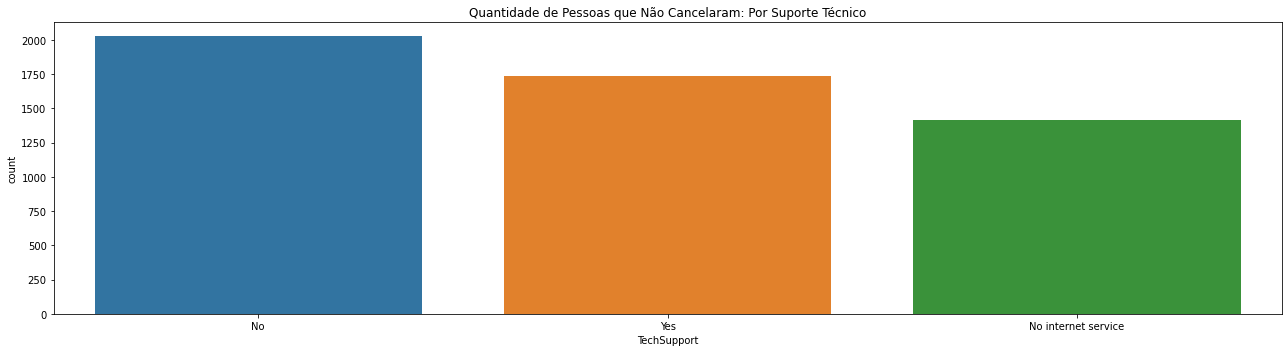

In [23]:
fig, ax = plt.subplots(figsize=(18, 5));
sns.countplot(df_no_churn.TechSupport);
plt.title("Quantidade de Pessoas que Não Cancelaram: Por Suporte Técnico");
plt.tight_layout();

### Mês

Por último, iremos ver quantos meses ficaram as pessoas que cancelaram sua assinatura.

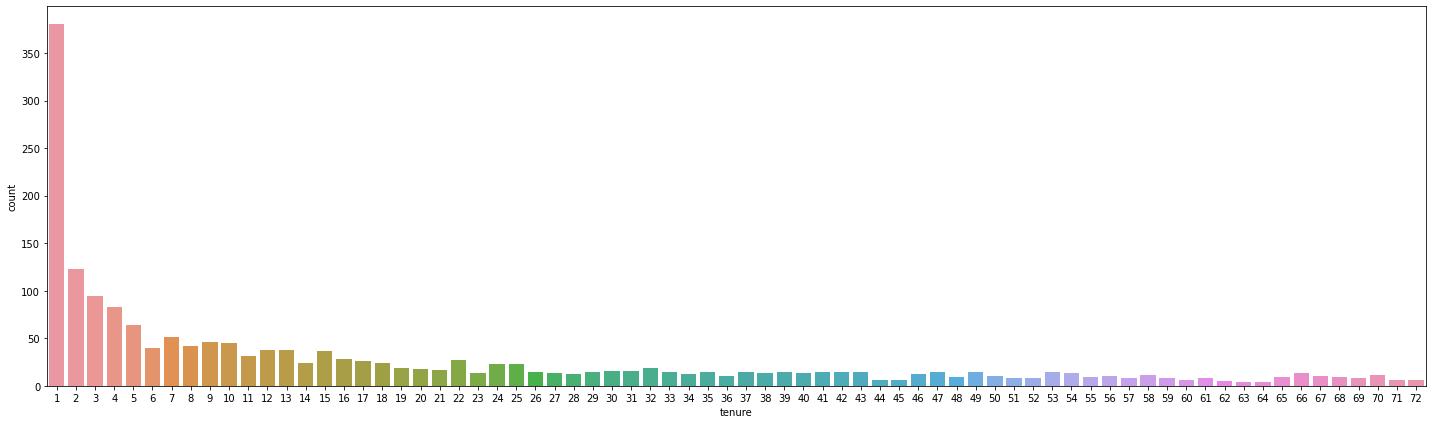

In [24]:
fig, ax = plt.subplots(figsize=(20, 6));
sns.countplot(df_churn.tenure);
plt.tight_layout();

Diante do gráfico acima, vemos que a maioria das pessoas cancelam sua assinatura no primeiro mês, quantidade que vai decrescendo até o sexto mês.

Por quê? 

Poderíamos supor, por exemplo, que com relação ao primeiro mês isso pode se dar devido a uma alta expectativa dos clientes que são decepcionados pelo recebido, sentimento que diminui (juntamente com os números de cancelamento) com o passar do tempo já que o cliente vai se acostumando/entendendo o produto! Em contrapartida, no sétimo mês a quantidade volta a aumentar, isso pode representar que alguns clientes cansaram da plataforma ou de tentar resolver os problemas.

Portanto, a empresa pode se atentar a como estão sendo feitas as propagandas sobre o que é oferecido e como está a qualidade do suporte

## Modelo de Machine Learning

Agora, vamos focar na criação do nosso modelo de Machine Learning para prever se uma pessoa tende a ser churn ou não.

### Preparação dos dados 

Antes de construirmos o modelo propriamente dito, precisamos fazer uma preparação nos dados que vai desde fazer a transformação das variáveis categóricas através do LabelEncoder até a transformação das mesmas em variáveis dummy.


In [25]:
# Pré-processamento das variáveis 
binary_var = df_new.nunique()[df_new.nunique() == 2].keys().tolist()
num_var = [col for col in df_new.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_new.columns.tolist() if col not in binary_var + num_var]

In [26]:
# Cópia do Dataset
df_model = df_new.copy()

In [27]:
# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df_model[i] = le.fit_transform(df_model[i])

# Encoding para colunas categóricas com múltiplas classes
df_model = pd.get_dummies(df_model, columns=cat_var)

In [28]:
# ver as 5 primeiras entradas do novo dataframe
df_model.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


In [29]:
df_model['pagamento'] = (df_model['MonthlyCharges']/df_model['TotalCharges'])

Na sequência, iremos separar a variável alvo, `Churn`, do dataset e criar a base de treinamento e de testes! 

In [30]:
# Separar o target vector
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# Dividir os dados entre treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y)

Para ver o recall do nosso modelo vamos criar a função abaixo.

In [31]:
def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

Como vimos antes, os dados de Churn estavam desbalanceados. Para balanceá-los, vamos fazer um Under Sampling, técnica que busca balancear esses dados da melhor forma possível.

Porém, antes para uma melhor otimização do Under Sampling vamos padronizar os dados.

In [32]:
# criar baseline e ver desempenho
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

Recall: 0.47 (+/- 0.03)


In [33]:
# Padronizar os  dados,
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

### Escolha dos Modelos

Vamos aplicar agora a validação cruzada em alguns modelos com o intuito de ver quais se saem melhor para posteriormente utilizá-los. Os modelos escolhidos são:

* Random Forest

* Decision Tree

* Stochastic Gradient Descent

* SVC

* Regressão Logística

* LightGBM

In [35]:
# instanciar modelos
rf = RandomForestClassifier(random_state=0)
dt = DecisionTreeClassifier(random_state=0)
sgdc = SGDClassifier(random_state=0)
svc = SVC(random_state=0)
lr = LogisticRegression(random_state=0)
xgb = XGBClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0)

model = []
recall = []
# avaliar o desempenho (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.780069
DecisionTreeClassifier,0.678230
SGDClassifier,0.776480
SVC,0.811160
LogisticRegression,0.800541
XGBClassifier,0.810458
LGBMClassifier,0.776513


Temos que a Regressão Logística ficou com o melhor resultado seguido respectivamente por XGCBoost, SVC e LGBM. 

Vamos agora ver como os parâmetros influenciam esses modelos tentando melhorá-los e ao fim escolher o que teve melhor desempenho! 

### Escolha dos Parâmetros do modelo:

Para a escolha dos parâmetros iremos utilizar a ferramenta GridSearchCV, nela escolhemos uma quantidade de parâmetros que vão ser testados e ao fim iremos ver qual obteve o melhor desempenho.

#### LGBM

In [36]:
lgbm = LGBMClassifier(random_state=0, learning_rate=0.01)

param_grid = {
 'boosting_type':['gbdt', 'rf', 'dart', 'goss']
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(lgbm, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7963140545400059 para {'boosting_type': 'gbdt'}


In [38]:
lgbm = LGBMClassifier(random_state=0, learning_rate=0.01, boosting_type='gbdt')

param_grid = {
 'sub_feature':[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(lgbm, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8379382679053041 para {'sub_feature': 0.05}


In [39]:
lgbm = LGBMClassifier(random_state=0, learning_rate=0.01, boosting_type='gbdt', sub_feature=0.05)

param_grid = {
 'num_leaves':range(0,50,1)
} 
# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(lgbm, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8451053840775147 para {'num_leaves': 16}


In [40]:
lgbm = LGBMClassifier(random_state=0, learning_rate=0.01, boosting_type='gbdt', sub_feature=0.05, num_leaves=16)

param_grid = {
 'learning_rate':[0.0001, 0.0005, 0.0007, 0.001, 0.003, 0.005, 0.007, 0.01, 0.05, 0.1]
} 
# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(lgbm, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.849390670262711 para {'learning_rate': 0.001}


              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1306
           1       0.51      0.81      0.63       455

    accuracy                           0.75      1761
   macro avg       0.71      0.77      0.72      1761
weighted avg       0.81      0.75      0.76      1761

AUC: 0.7703



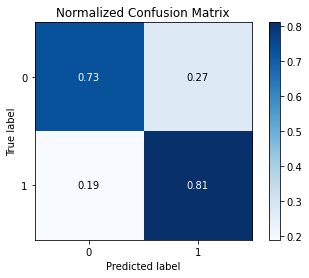

In [41]:
# modelo final
lgbm = LGBMClassifier(random_state=0, learning_rate=0.001, boosting_type='gbdt', sub_feature=0.5, num_leaves=16)
lgbm.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = lgbm.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

#### SVC

In [42]:
svc = SVC(random_state=0)

param_grid = {
 'kernel':['linear', 'poly', 'rbf', 'sigmoid']
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(svc, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8210168814304266 para {'kernel': 'linear'}


In [35]:
svc = SVC(random_state=0, kernel='linear')

param_grid = {
 'tol':[0.001, 0.01, 0.1, 1, 2]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(svc, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8326241134751774 para {'tol': 2}


In [36]:
svc = SVC(random_state=0, kernel='linear', tol=2)

param_grid = {
 'gamma':[i/10.0 for i in range(1,10)]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(svc, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8302929085303186 para {'gamma': 0.1}


              precision    recall  f1-score   support

           0       0.89      0.62      0.73      1288
           1       0.44      0.80      0.57       473

    accuracy                           0.67      1761
   macro avg       0.67      0.71      0.65      1761
weighted avg       0.77      0.67      0.69      1761

AUC: 0.7116



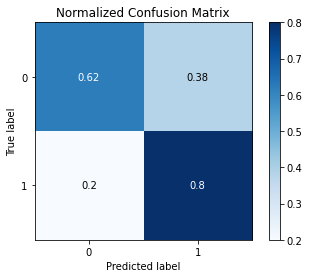

In [37]:
# modelo final
svc = SVC(random_state=0, kernel='linear', tol=2, C=1, gamma=0.1)
svc.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = svc.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

#### Logistic

In [40]:
logistic = LogisticRegression(random_state=0)

param_grid = {
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(logistic, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8188232271325797 para {'solver': 'newton-cg'}


In [42]:
logistic = LogisticRegression(solver='newton-cg', random_state=0)

param_grid = {
 'multi_class' : ['auto', 'ovr', 'multinomial']
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(logistic, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8181038026721479 para {'multi_class': 'multinomial'}


In [43]:
logistic = LogisticRegression(solver='newton-cg', multi_class='auto', max_iter=1,  random_state=0)

param_grid = {
 'tol' : [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
}
# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(logistic, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8774563206577595 para {'tol': 1e-05}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.91      0.62      0.74      1288
           1       0.45      0.84      0.58       473

    accuracy                           0.68      1761
   macro avg       0.68      0.73      0.66      1761
weighted avg       0.79      0.68      0.70      1761

AUC: 0.7291



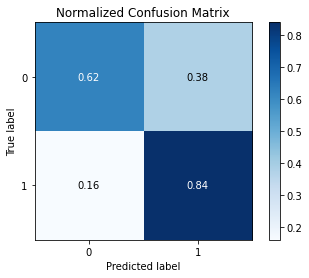

In [44]:
# modelo final
logistic = LogisticRegression(solver='newton-cg', multi_class='auto', max_iter=1, random_state=0, tol=0.00005)
logistic.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = logistic.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

#### XGBOOST

Começaremos analisando o parâmetro **n_estimators**.

In [45]:
xgb = XGBClassifier(random_state=0)

param_grid = {
 'learning_rate':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8215107913669064 para {'learning_rate': 0.05}


Logo o melhor parâmetro dos treinados foi de 0.05. Veremos agora **n_estimators**.

In [46]:
xgb = XGBClassifier(learning_rate=0.05, random_state=0)

param_grid = {
 'n_estimators':range(0,500,50),
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8302877697841728 para {'n_estimators': 50}


Na sequência, vamos analisar **max_depth** e **min_child_weight**. 

In [48]:
xgb = XGBClassifier(learning_rate=0.05, n_estimators=50, random_state=0)

param_grid = {
 'max_depth':range(1,5,1),
 'min_child_weight':range(1,5,1)
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8395426515930113 para {'max_depth': 1, 'min_child_weight': 1}


Agora vamos ver **gamma**.

In [49]:
xgb = XGBClassifier(learning_rate=0.05, n_estimators=50, max_depth=1, min_child_weight=1, random_state=0)

param_grid = {
 'gamma':[i/10.0 for i in range(0,10)]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8409044193216856 para {'gamma': 0.0}


Por último, vamos voltar para o **learning_rate** e ver se a escolha de 0.01 foi a melhor.

In [51]:
xgb = XGBClassifier(learning_rate=0.05, n_estimators=50, max_depth=1, min_child_weight=1, random_state=0, gamma=0.0)

param_grid = {
 'learning_rate':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8875334018499487 para {'learning_rate': 0.0001}


Agora, treina-se o modelo em cima do dataset de treino completo, e verifica-se o desempenho final em cima dos dados de teste, no seu primeiro contato com esse sub-conjunto que havia sido preservado.

              precision    recall  f1-score   support

           0       0.94      0.61      0.74      1283
           1       0.46      0.90      0.61       478

    accuracy                           0.69      1761
   macro avg       0.70      0.75      0.67      1761
weighted avg       0.81      0.69      0.70      1761

AUC: 0.7519



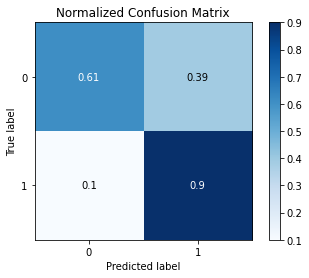

In [34]:
# modelo final
xgb = XGBClassifier(learning_rate=0.0001, n_estimators=50, max_depth=1, min_child_weight=1, random_state=0, gamma=0.0)
xgb.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

## Final

Durante o projeto, inicialmente fizemos uma investigação na integridade dos dados procurando por falhas nos tipos e dados faltantes. 

Na sequência, fizemos um diagnóstico sobre as características das pessoas classificadas como Churn. Vimos, primeiramente, que por uma quantidade pequena (como vemos na imagem abaixo), mulheres são as que mais cancelam sua assinatura.



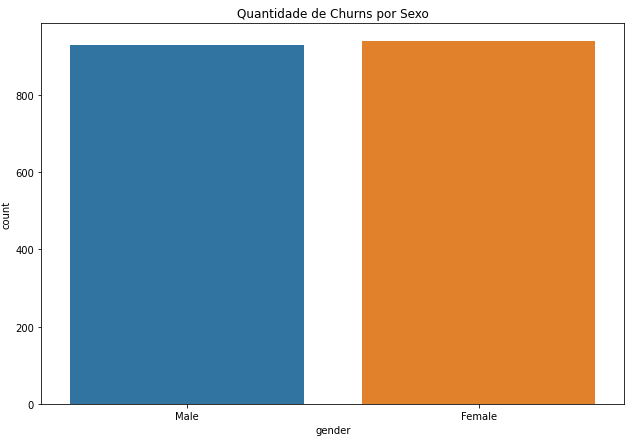

Em seguida, que a maioria dos Churns possuem cheque eletrônico como forma de pagamento além de não gostarem do suporte técnico. Por último, que a maior parte dos clientes saem da empresa nos primeiros cinco meses (grande maioria no primeiro!).

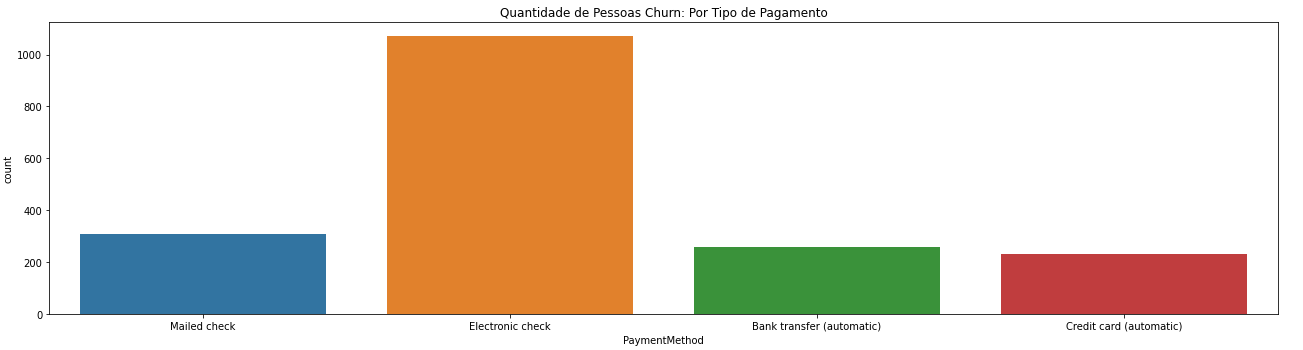

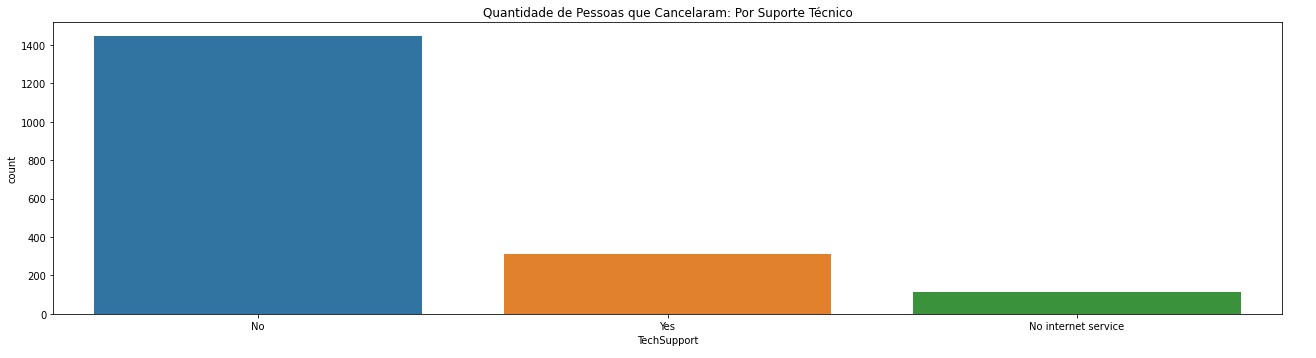

Visto isso, tentamos prever se um cliente tem características de ser um Churn ou não. Para isso, preparamos os dados para podermos analisar a eficiência de 8 modelos de machine learning no nosso dataset. Dentre os 8, escolhemos 4 e descobrimos os melhores valores dos parâmetros para a melhor optimização de cada um, com isso vimos que o Modelo XGBoost teve o melhor desempenho de recall com 90%!  

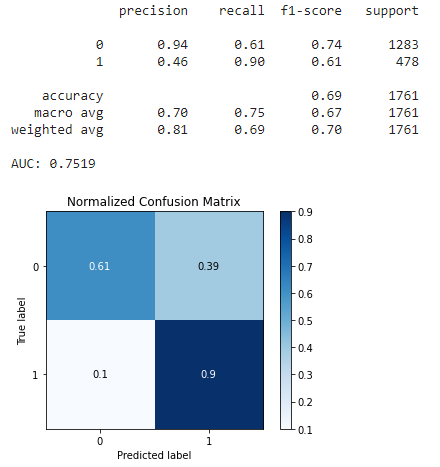